# Image Processing Playground
## Author: Dimitri Lezcano
This is an image processing playground Python Notebook in order to test image processing solutions.

## Imports

In [4]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

# pltting tools
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting @UnusedImport

# NURBS
from geomdl import fitting
from geomdl.visualization import VisMPL

# custom code
from stereo_needle_proc import *
from BSpline1D import BSpline1D

## Image Files

In [5]:
# directory settings
stereo_dir = "../Test Images/stereo_needle/"
needle_dir = stereo_dir + "needle_examples/"  # needle insertion examples directory
grid_dir = stereo_dir + "grid_only/"  # grid testing directory
valid_dir = stereo_dir + "stereo_validation_jig/"  # validation directory

curvature_dir = sorted(glob.glob( valid_dir + 'k_*/' ))  # validation curvature directories

# load matlab stereo calibration parameters
stereo_param_dir = "../Stereo_Camera_Calibration_10-23-2020"
stereo_param_file = stereo_param_dir + "/calibrationSession_params-error_opencv-struct.mat"
stereo_params = load_stereoparams_matlab( stereo_param_file )

(768, 1024, 3) (768, 1024, 3)


Text(0.5, 1.0, 'Raw imags')

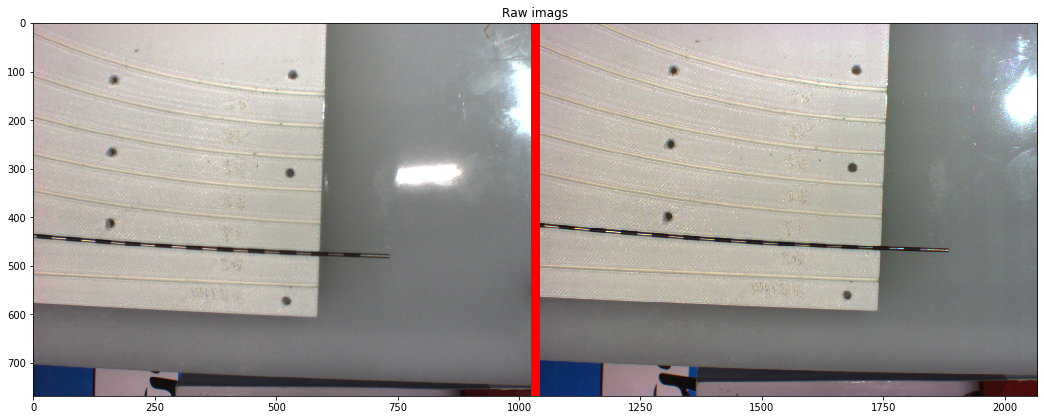

In [6]:
# image files
img_num = 5
left_file = curvature_dir[0] + f"left-{img_num:04d}.png"
right_file = curvature_dir[0] + f"right-{img_num:04d}.png"

# load the images
left_img = cv2.imread(left_file, cv2.IMREAD_ANYCOLOR)
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_img = cv2.imread(right_file, cv2.IMREAD_ANYCOLOR)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

# show the images
print(left_img.shape, right_img.shape)
plt.figure(figsize=(18,12))
plt.imshow(imconcat(left_img, right_img, [255,0, 0]))
plt.title('Raw imags')

## Image Processing
Image processing functions to test.

In [7]:
def imgproc_jig( left_img, right_img,
                         bor_l:list = [], bor_r:list = [],
                         roi_l:tuple = (), roi_r:tuple = (),
                         proc_show: bool = False ):
    ''' wrapper function to process the left and right image pair for needle
        centerline identification
        
     '''
    
    # convert to grayscale if not already
    if left_img.ndim > 2:
        left_img = cv2.cvtColor( left_img, cv2.COLOR_BGR2GRAY )

    # if
    if right_img.ndim > 2:
        right_img = cv2.cvtColor( right_img, cv2.COLOR_BGR2GRAY )

    # if
    
#     # image processing 1
#     left_canny, right_canny = canny(left_img, right_img, lo_thresh=150, hi_thresh=200)
#     left_roi1 = roi( left_canny, roi_l, full = True )
#     right_roi1 = roi( right_canny, roi_r, full = True )
    
#     left_thresh_bo1 = blackout_regions( left_roi1, bor_l )
#     right_thresh_bo1 = blackout_regions( right_roi1, bor_r )
    
#     left_close1, right_close1 = bin_close( left_thresh_bo1, right_thresh_bo1, ksize = ( 7, 7 ) )
    
    # start the image qprocessing
    left_thresh, right_thresh = thresh( left_img, right_img, thresh=80 )
    
    left_roi = roi( left_thresh, roi_l, full = True )
    right_roi = roi( right_thresh, roi_r, full = True )
    
    left_thresh_bo = blackout_regions( left_roi, bor_l )
    right_thresh_bo = blackout_regions( right_roi, bor_r )
        
    left_tmed, right_tmed = median_blur( left_thresh_bo, right_thresh_bo, ksize = 7 )
    
    left_close, right_close = bin_close( left_tmed, right_tmed, ksize = ( 7, 7 ) )
    
    left_open, right_open = bin_open( left_close, right_close, ksize = ( 3, 3 ) )
    
    left_dil, right_dil = bin_dilate( left_close, right_close, ksize = ( 0, 0 ) )
    
    left_skel, right_skel = skeleton( left_dil, right_dil )
    
    # get the contours ( sorted by length)
    conts_l, conts_r = contours( left_skel, right_skel )
    
    # fit a bspline to the contours
    pts_l = np.unique(np.vstack(conts_l[:-5]).squeeze(), axis=0)
    pts_r = np.unique(np.vstack(conts_r[:-5]).squeeze(), axis=0)
    bspline_l = BSpline1D(pts_l[:,0], pts_l[:,1], k=3)
    bspline_r = BSpline1D(pts_r[:,0], pts_r[:,1], k=3)
        
    # grab all of the bspline points
    s = np.linspace(0, 1, 200)
    bspline_pts_l = np.vstack((bspline_l.unscale(s), bspline_l(bspline_l.unscale(s)))).T
    bspline_pts_r = np.vstack((bspline_r.unscale(s), bspline_r(bspline_r.unscale(s)))).T
    
    if proc_show:
        plt.ion()
        
#         plt.figure(figsize=(18,12))
#         plt.imshow(imconcat(left_canny, right_canny, 150), cmap='gray')
#         plt.title('canny')
        
#         plt.figure(figsize=(18,12))
#         plt.imshow( imconcat( left_roi1, right_roi1, 150 ), cmap = 'gray' )
#         plt.title( 'roi: after canny' )
        
#         plt.figure(figsize=(18,12))
#         plt.imshow( imconcat( left_thresh_bo1, right_thresh_bo1, 150 ), cmap = 'gray' )
#         plt.title( 'region suppression: roi' )
        
#         plt.figure(figsize=(18,12))
#         plt.imshow( imconcat( left_close1, right_close1, 150 ), cmap = 'gray' )
#         plt.title( 'closing: after region suppression' )
        
        # try 2
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_thresh, right_thresh, 150 ), cmap = 'gray' )
        plt.title( 'adaptive thresholding' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_roi, right_roi, 150 ), cmap = 'gray' )
        plt.title( 'roi: after thresholding' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_thresh_bo, right_thresh_bo, 150 ), cmap = 'gray' )
        plt.title( 'region suppression: roi' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_tmed, right_tmed, 150 ), cmap = 'gray' )
        plt.title( 'median filtering: after region suppression' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_close, right_close, 150 ), cmap = 'gray' )
        plt.title( 'closing: after median' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_open, right_open, 150 ), cmap = 'gray' )
        plt.title( 'opening: after closing' )

        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_open, right_open, 150 ), cmap = 'gray' )
        plt.title( 'dilation: after closing' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_skel, right_skel, 150 ), cmap = 'gray' )
        plt.title( 'skeletization: after dilation' )
        
        cont_left = left_img.copy().astype( np.uint8 )
        cont_right = right_img.copy().astype( np.uint8 )
        
        cont_left = cv2.cvtColor( cont_left, cv2.COLOR_GRAY2RGB )
        cont_right = cv2.cvtColor( cont_right, cv2.COLOR_GRAY2RGB )
        
        cv2.drawContours( cont_left, conts_l[:-5], -1, ( 255, 0, 0 ), 6 )
        cv2.drawContours( cont_right, conts_r[:-5], -1, ( 255, 0, 0 ), 6 )
        
        cv2.drawContours( cont_left, conts_l, 0, ( 0, 255, 0 ), 3 )
        cv2.drawContours( cont_right, conts_r, 0, ( 0, 255, 0 ), 3 )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( cont_left, cont_right, 150 ), cmap = 'gray' )
        plt.title( 'contours' )
        
        impad = 20
        bspl_left_img = cv2.cvtColor(left_img.copy().astype(np.uint8), cv2.COLOR_GRAY2RGB)
        bspl_right_img = cv2.cvtColor(right_img.copy().astype(np.uint8), cv2.COLOR_GRAY2RGB)
        
        plt.figure(figsize=(18,12))
        plt.imshow(imconcat(bspl_left_img, bspl_right_img, [0, 0, 255],pad_size=impad))
        plt.plot(bspline_pts_l[:,0], bspline_pts_l[:,1], 'r-')
        plt.plot(bspline_pts_r[:,0]  + left_img.shape[1] + impad, bspline_pts_r[:,1], 'r-')
        plt.title('bspline fits')
        
        
    # if
    
    return left_skel, right_skel, [np.expand_dims(bspline_pts_l, axis=1)], [np.expand_dims(bspline_pts_r, axis=1)]
    
# imgproc_jig


## Testing Image Processing

### Region-of-Interest Mappings

In [151]:
# list of ROIs (empty)''
curv_dir_num = 4
roi_file = curvature_dir[curv_dir_num] + 'rois_lr.npy'

try:
    rois_lr = np.load(roi_file)
    print('Found rois file:', roi_file)
    rois_l = rois_lr[:, :, 0:2].tolist()
    rois_r = rois_lr[:, :, 2:4].tolist()
    
# try

except:
    print('Did not find rois file:', roi_file)
    print('Loaded empty rois...')

    rois_l = [[[0,0], [-1,-1]]]*10
    rois_r = [[[0,0], [-1,-1]]]*10
    
# except

print('rois_l:', type(rois_l), np.shape(rois_l))
print('rois_r:', type(rois_r), np.shape(rois_r))


Did not find rois file: ../Test Images/stereo_needle/stereo_validation_jig/k_4.0/rois_lr.npy
Loaded empty rois...
rois_l: <class 'list'> (10, 2, 2)
rois_r: <class 'list'> (10, 2, 2)


In [165]:
# load the stereo pair
img_num = 10
save = True

left_file = curvature_dir[curv_dir_num] + f"left-{img_num:04d}.png"
right_file = curvature_dir[curv_dir_num] + f"right-{img_num:04d}.png"

left_img = cv2.imread(left_file, cv2.IMREAD_ANYCOLOR)
right_img = cv2.imread(right_file, cv2.IMREAD_ANYCOLOR)

if (left_img is None) or (right_img is None):
    print(f"Image pair number: '{img_num}' is not found.")
    
#if

left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

# try the ROI
roi_l = [[0,0], [600, 460 + 35*(img_num)]]
roi_r = [[0,0], [roi_l[1][0], roi_l[1][1] + 110]]

left_roi = roi(left_img, roi_l, full=True)
right_roi = roi(right_img, roi_r, full=True)

plt.figure(figsize=(18,12))
plt.imshow(imconcat(left_roi, right_roi, [0, 0, 255]))
plt.title('Left-Right ROI')

if img_num + 1> len(rois_l):
    rois_l += [[[0,0], [-1,-1]]]*10
    print('Expanded rois_l to length:', len(rois_l), np.shape(rois_l))

# if

if img_num + 1 > len(rois_r):
    rois_r += [[[0,0], [-1,-1]]]*10
    print('Expanded rois_r to length:', len(rois_r), np.shape(rois_r))
    
# if

print()

rois_l[img_num] = roi_l
print(f"Added left roi: {roi_l} to rois[{img_num}]")

rois_r[img_num] = roi_r
print(f"Added right roi: {roi_r} to rois[{img_num}]")

if save:
    rois_lr = np.concatenate((rois_l, rois_r), axis=2).astype(int)
    np.save(curvature_dir[curv_dir_num] + "rois_lr.npy", rois_lr)
    print('Saved rois to npy file:', curvature_dir[curv_dir_num] + 'rois_lr.npy')


Image pair number: '10' is not found.


error: OpenCV(4.1.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [112]:
len(rois_r)

10

### Image Processing Steps

In [10]:
roi_l = [[0,0], [500,750]]
roi_r = [[0,0], [500,850]]
res = imgproc_jig(left_img, right_img,
                  roi_l = roi_l, roi_r = roi_r,
                  proc_show=True)

AttributeError: 'NoneType' object has no attribute 'ndim'

In [11]:
pts = np.vstack(res[2][:-5]).squeeze()
pts = np.unique(pts, axis=0)
print(pts.shape)
b = BSpline1D(pts[:,0], pts[:,1], k=3)

plt.plot(pts[:,0], pts[:,1])

s = np.linspace(0, 1, 200)

plt.plot(b.unscale(s), b(b.unscale(s)))
plt.legend(['pts', 'bspline'])

NameError: name 'res' is not defined

In [145]:
print(len(res[2]), res[2][0].shape)
b = np.random.randn(10,2)
print(b.shape, np.expand_dims(b, axis=1).shape)

13 (488, 1, 2)
(10, 2) (10, 1, 2)
